In [9]:
%load_ext autoreload
%autoreload 2
import timeit
import pickle
import numpy as np
import matplotlib.pyplot as plt
from shape import Shape, Block, plot_hulls
from convex_hulls_graph import HullGraph
from shapely.geometry import Point, Polygon
from shapely.affinity import rotate
import shapely.ops as ops
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints
from multiboat_trajectory_optimization.boat_models import Boat, TwoInputBoat
from multiboat_trajectory_optimization.trajectory_planner import BoatConfigurationPlanning, B_i_k, knots_to_trajectory, knots_to_trajectory2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
from pydrake.all import MathematicalProgram

mp = MathematicalProgram()

mp.

In [13]:
from pypolypart import pypolypart
poly1 = [(0,0),(10,0), (9,5), (10,10),(0,10)]
poly2 = [(99+0,0),(99+10,0), (99+9,5), (99+10,10),(99+0,10)]
hole1 = [(1,1),(1,3), (3,1)]
print pypolypart.polys_to_tris_and_hulls([poly1, poly2], [hole1])

{'hulls': [[(99.0, 0.0), (109.0, 0.0), (108.0, 5.0), (99.0, 10.0)], [(99.0, 10.0), (108.0, 5.0), (109.0, 10.0)], [(0.0, 0.0), (10.0, 0.0), (3.0, 1.0), (1.0, 1.0)], [(0.0, 10.0), (0.0, 0.0), (1.0, 1.0), (1.0, 3.0)], [(1.0, 3.0), (3.0, 1.0), (10.0, 0.0), (9.0, 5.0), (0.0, 10.0)], [(9.0, 5.0), (10.0, 10.0), (0.0, 10.0)]], 'triangles': [[(99.0, 0.0), (109.0, 0.0), (108.0, 5.0)], [(99.0, 10.0), (99.0, 0.0), (108.0, 5.0)], [(99.0, 10.0), (108.0, 5.0), (109.0, 10.0)], [(0.0, 0.0), (10.0, 0.0), (3.0, 1.0)], [(0.0, 0.0), (3.0, 1.0), (1.0, 1.0)], [(0.0, 10.0), (0.0, 0.0), (1.0, 1.0)], [(0.0, 10.0), (1.0, 1.0), (1.0, 3.0)], [(3.0, 1.0), (10.0, 0.0), (9.0, 5.0)], [(9.0, 5.0), (10.0, 10.0), (0.0, 10.0)], [(9.0, 5.0), (0.0, 10.0), (1.0, 3.0)], [(9.0, 5.0), (1.0, 3.0), (3.0, 1.0)]]}


{'hulls': [], 'triangles': [[(1000.0, -1000.0), (1000.0, 1000.0), (245.00000000000003, 150.0)], [(1000.0, -1000.0), (245.00000000000003, 150.0), (245.00000000000003, 50.0)], [(244.0, 151.0), (245.00000000000003, 150.0), (1000.0, 1000.0)], [(244.0, 155.0), (244.0, 151.0), (1000.0, 1000.0)], [(241.0, 161.0), (244.0, 155.0), (1000.0, 1000.0)], [(240.0, 162.0), (241.0, 161.0), (1000.0, 1000.0)], [(239.0, 164.0), (240.0, 162.0), (1000.0, 1000.0)], [(239.0, 164.0), (1000.0, 1000.0), (-1000.0, 1000.0)], [(155.0, 55.00000000000001), (155.0, 30.0), (175.0, 30.0)], [(155.0, 55.00000000000001), (175.0, 30.0), (176.0, 31.0)], [(-75.0, 30.0), (-55.00000000000001, 30.0), (-55.00000000000001, 55.00000000000001)], [(-76.0, 31.0), (-75.0, 30.0), (-55.00000000000001, 55.00000000000001)], [(-5.0, 155.0), (-5.0, 120.0), (105.0, 120.0)], [(-5.0, 155.0), (105.0, 120.0), (105.0, 155.0)], [(176.0, 69.0), (175.0, 70.0), (173.0, 69.0)], [(-73.0, 69.0), (-75.0, 70.0), (-76.0, 69.0)], [(158.0, 61.0), (155.0, 55.0

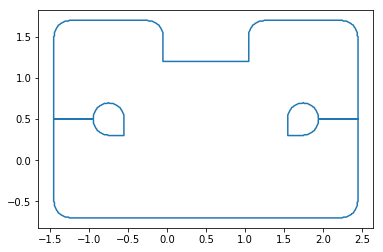

In [38]:
x = ((2.37,-0.65),(2.39,-0.64),(2.4,-0.62),(2.41,-0.61),(2.44,-0.55),(2.44,-0.51),(2.45,-0.5),(2.45,0.5),(1.95,0.5),(1.94,0.49),(1.94,0.45),(1.91,0.39),(1.9,0.38),(1.89,0.36),(1.87,0.35),(1.86,0.34),(1.8,0.31),(1.76,0.31),(1.75,0.3),(1.55,0.3),(1.55,0.55),(1.58,0.61),(1.59,0.62),(1.6,0.64),(1.62,0.65),(1.63,0.66),(1.69,0.6899999999999999),(1.73,0.6899999999999999),(1.75,0.7),(1.76,0.6899999999999999),(1.8,0.6899999999999999),(1.86,0.66),(1.87,0.65),(1.89,0.64),(1.9,0.62),(1.91,0.61),(1.94,0.55),(1.94,0.51),(1.95,0.5),(2.45,0.5),(2.45,1.5),(2.44,1.51),(2.44,1.55),(2.41,1.61),(2.4,1.62),(2.39,1.64),(2.37,1.65),(2.36,1.66),(2.3,1.69),(2.26,1.69),(2.25,1.7),(1.25,1.7),(1.23,1.69),(1.19,1.69),(1.13,1.66),(1.12,1.65),(1.1,1.64),(1.09,1.62),(1.08,1.61),(1.05,1.55),(1.05,1.2),(-0.05,1.2),(-0.05,1.55),(-0.08,1.61),(-0.09,1.62),(-0.1,1.64),(-0.12,1.65),(-0.13,1.66),(-0.19,1.69),(-0.23,1.69),(-0.25,1.7),(-1.25,1.7),(-1.26,1.69),(-1.3,1.69),(-1.36,1.66),(-1.37,1.65),(-1.39,1.64),(-1.4,1.62),(-1.41,1.61),(-1.44,1.55),(-1.44,1.51),(-1.45,1.5),(-1.45,0.5),(-0.95,0.5),(-0.9399999999999999,0.51),(-0.9399999999999999,0.55),(-0.91,0.61),(-0.9,0.62),(-0.89,0.64),(-0.87,0.65),(-0.86,0.66),(-0.8,0.6899999999999999),(-0.76,0.6899999999999999),(-0.75,0.7),(-0.73,0.6899999999999999),(-0.6899999999999999,0.6899999999999999),(-0.63,0.66),(-0.62,0.65),(-0.6,0.64),(-0.59,0.62),(-0.58,0.61),(-0.55,0.55),(-0.55,0.3),(-0.75,0.3),(-0.76,0.31),(-0.8,0.31),(-0.86,0.34),(-0.87,0.35),(-0.89,0.36),(-0.9,0.38),(-0.91,0.39),(-0.9399999999999999,0.45),(-0.9399999999999999,0.49),(-0.95,0.5),(-1.45,0.5),(-1.45,-0.5),(-1.44,-0.51),(-1.44,-0.55),(-1.41,-0.61),(-1.4,-0.62),(-1.39,-0.64),(-1.37,-0.65),(-1.36,-0.66),(-1.3,-0.6899999999999999),(-1.26,-0.6899999999999999),(-1.25,-0.7),(2.25,-0.7),(2.26,-0.6899999999999999),(2.3,-0.6899999999999999),(2.36,-0.66))
y = ((10,10),(-10,10),(-10,-10),(10,-10))

plt.plot(*zip(*x))

x = [(100*a, 100*b) for (a,b) in x]
y = [(100*a, 100*b) for (a,b) in y]

print pypolypart.polys_to_tris_and_hulls([y], [x[::-1]])

### Composing Shapes from Blocks

In [14]:

shape_a = Shape([Block(-0.75,0.5,90),Block(0,0.25,0),Block(1,0.25,0),Block(1.75,.5,90)])
shape_b = Shape([Block(0,0)])#,Block(1,0.25),Block(0,-0.25)])
shape_c = Shape([Block(1.0,0.25)])

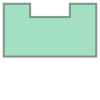

In [3]:
c = Polygon([[1,0],[2,-0.1],[1,1]])
b = Polygon([[5,4],[4,3.1],[3,-1]])
c.union(b).type

Polygon([(1.25, 1.5), (1.25, 1.0), (-0.25, 1.0), (-0.25, 1.5), (-1.25, 1.5), (-1.25, -0.5), (2.25, -0.5), (2.25, 1.5), (1.25, 1.5)])

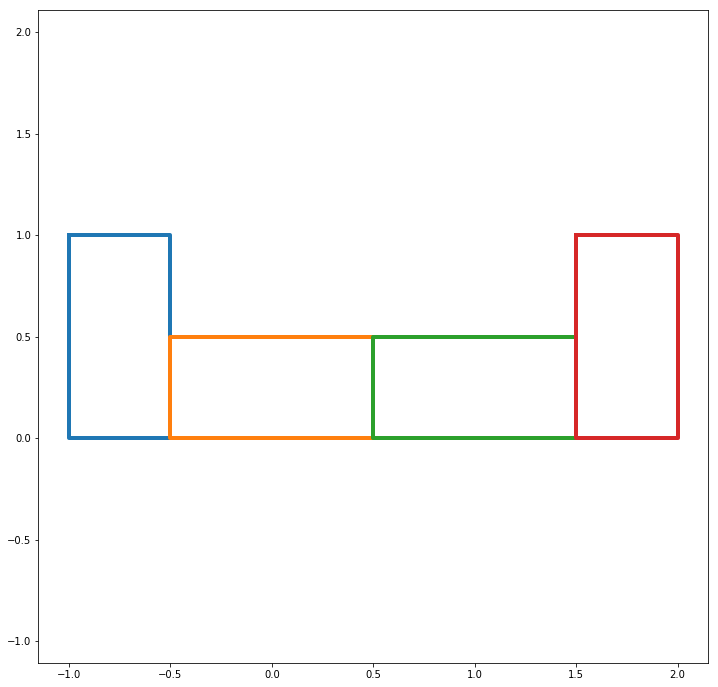

In [30]:
shape_a.plot(union=False)

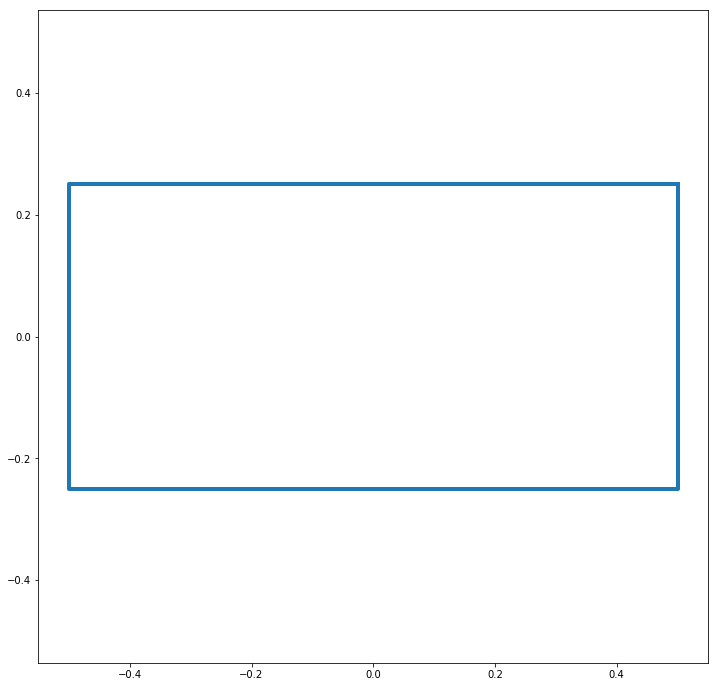

In [31]:
shape_b.plot(union=False)

### Pymesh minkowski sum

In [5]:
%load_ext autoreload
%autoreload 2
msums, hulls = shape_a.c_space_rotate(shape_b)

#shape_a.plot_msums(msums)
#shape_a.plot(union=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Partitioning of convex hulls around shape

In [6]:
hulls = shape_a.partition_around(buffered=False)
#plot_hulls(hulls, text=False)

### C-Space of a given obstacle b

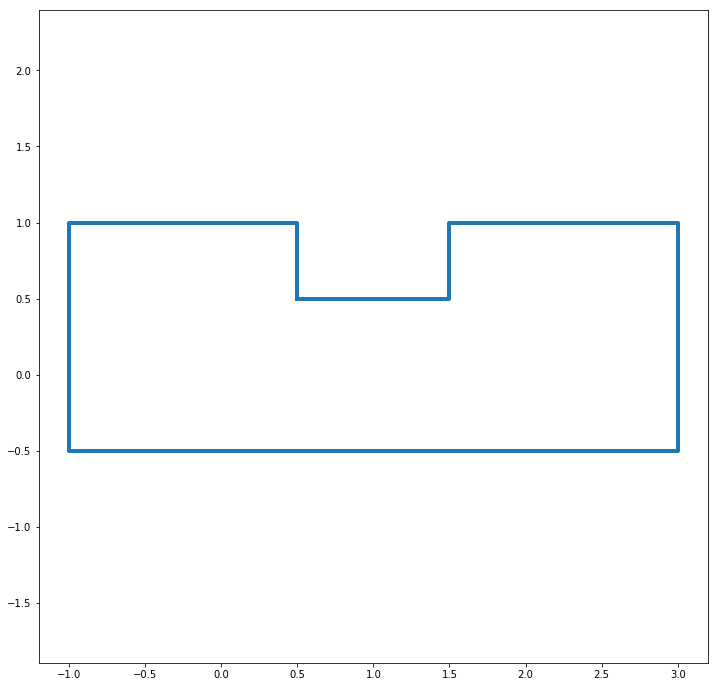

In [7]:
ab = shape_a.c_space(shape_b)
ab.plot(union=True)

### Finding Convex Hull of C-Space

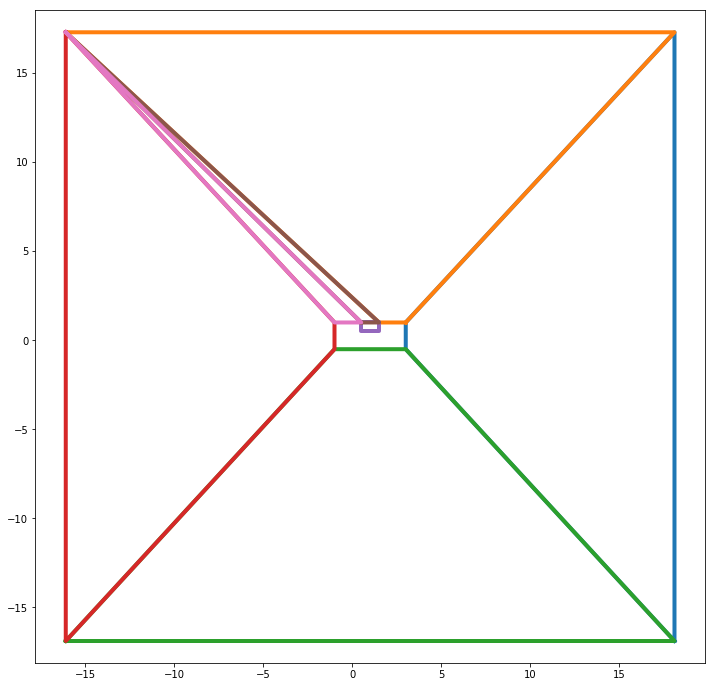

In [8]:
hulls = ab.partition_around(buffered=False)
ab.plot_polygons(hulls)

In [9]:
shape_a.polygon.intersection(shape_b.polygon).area>0
np.array(zip(*shape_a.polygon.intersection(shape_b.polygon).boundary.xy))

array([[ 0.5,  0. ],
       [-0.5,  0. ],
       [-0.5,  0.5],
       [ 0.5,  0.5],
       [ 0.5,  0. ]])

## Trajectory Planning

In [57]:
%load_ext autoreload
%autoreload 2
from shape_boat import ShapeBoat, ShapeBoat_spline, check_vertex_constraints

def experiment(boat_shape, obstacle_shape, xy0, xyN, margin=0, boat_type=ShapeBoat):
    x0 = np.zeros((1, boat_type.num_states))
    xN = np.zeros((1, boat_type.num_states))
    x0[0, :2] = xy0
    xN[0, :2] = xyN
    boat = boat_type(boat_shape, obstacle_shape)
    boat.set_end_points(x0, xN)
    planner = BoatConfigurationPlanning(boat)
    boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_trajectory(0., 10, x0, xN, time_cost=False, input_cost=True, slack=0, N=100)
    return boat, boats_S, boats_U

def experiment_spline(boat_shape, obstacle_shape, xy0, xyN, N=10, margin=0.0, boat_type=ShapeBoat_spline):
    x0 = np.zeros((1, boat_type.num_states))
    xN = np.zeros((1, boat_type.num_states))
    x0[0, :3] = xy0
    xN[0, :3] = xyN
    boat = boat_type(boat_shape, obstacle_shape, margin=margin)
    print "WOW"
    boat.set_end_points(x0, xN)
    planner = BoatConfigurationPlanning(boat)
    boats_S, boats_U, time_array, mp, result, solve_time = planner.compute_spline_trajectory(0., 10, x0, xN, input_cost=True, slack=0, N=N)
    return boat, boats_S, boats_U, mp

def write_experiment(boat, boats_S, boats_U, label):
    with open('results/path_'+label+'.pickle', 'wb') as f:
        pickle.dump([boat,boats_S,boats_U], f)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## MIQP - b-splines

WOW
LINESTRING (1.25 1.7, 2.269603428065912 1.699036945334439, 2.426384252869671 1.594279347365199, 2.45 -0.5, 2.376878656832729 -0.6546020906725474, -1.25 -0.7, -1.404602090672547 -0.6268786568327297, -1.45 1.5, -1.376878656832729 1.654602090672547, -0.2109819355967744 1.696157056080646, -0.05861193285355823 1.558056935450892, -0.04999999999999999 1.2, 1.05 1.2, 1.065224093497743 1.576536686473018, 1.25 1.7)
LINESTRING (-1.627718166290094 -0.4083136212379865, -1.748981540630943 -0.1101580378047196, -1.745936535118635 1.130110774184797, -1.594602090672547 1.466878656832729, -1.205792574299841 1.72886857114671, -0.3567385732225228 1.742777645015254, -0.0639097801265445 1.61655869832526, 0.213352653675646 1.25, 0.786647346324354 1.25, 1.02857864376269 1.591421356237309, 1.260610750453013 1.717577002980925, 2.109867109545854 1.749010798597194, 2.442051593461411 1.615663636332053, 2.687958684697688 1.318348612617341, 2.746044514404751 -0.1295796459282472, 2.590411776227052 -0.4718191851447

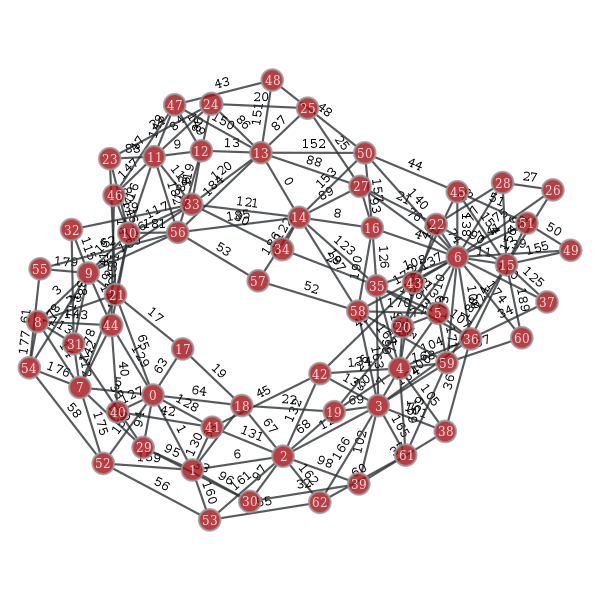

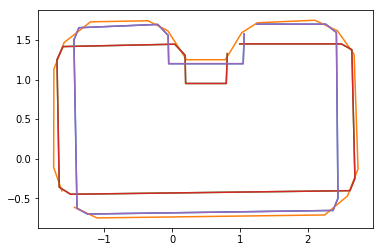

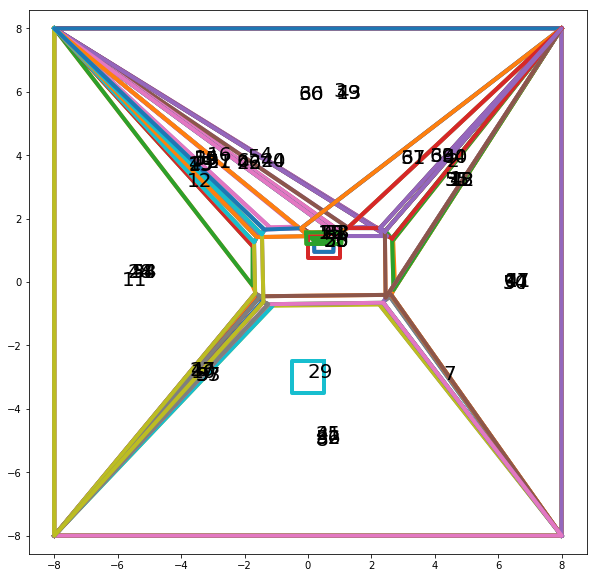

finding_vertex POINT (0 -3) 180.0
0 360
finding_vertex POINT (0.5 1) 0.0
0 0
8 49
INITIALIZED 1 ShapeBoat_spline boats
boats_S:(1, 15, 8), boats_U:(1, 14, 3), time_array:(15,)
Number of decision vars 162
0.001571 seconds
ADDING COSTS
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
SHAPE (3, 2)
0.023066 seconds
ADDING CONSTRAINTS
0.289862 seconds
PLANNING
SolutionResult.kSolutionFound
1.654706 seconds

[8, 9, 33, 34, 35, 6, 49]
0 (0, 360)
1 (0, 360)
2 (270, 270)
3 (270, 270)
4 (270, 270)
5 (0, 360)
6 (0, 0)


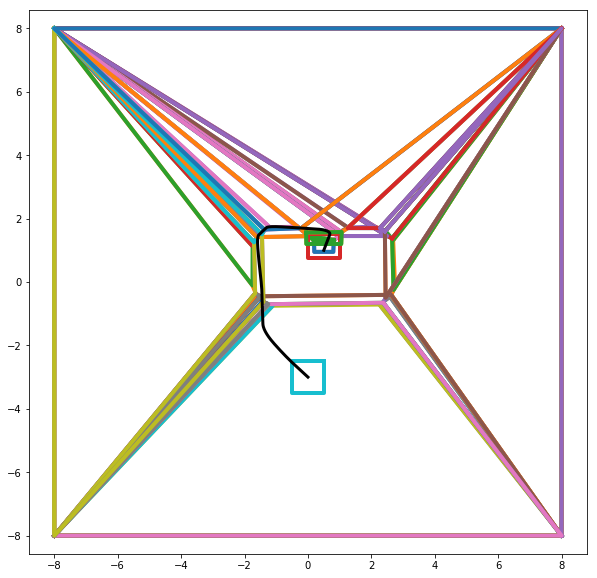

other_boat_pos (3, 4)


In [58]:
p = [[3,0.5], [-3,0.5], 'past']
a1 = [[3,0.5], [-1.11,1.], 'around1']
a2 = [[1,0], [-1.11,1.], 'around2']

boat, boats_S, boats_U, mp = experiment_spline(shape_b, shape_a, [0,-3, 180], [0.5,1.0, 0], N=14)
#boats_S = np.array([[[0.,1.],[0.1,1.5],[0.5,2.0],[0.6,-1.],[-1., -2.], [-3.,-3.]]])
boats_S_new = knots_to_trajectory2(boats_S, 497)

print boat.path

for i,hull in enumerate(boat.hull_path):
    print i, (hull["min_angle"], hull["max_angle"])

plt.figure(figsize=(10,10))
plot_hulls([x for a in boat.hulls.values() for x in a], (boats_S_new[0,:,0], boats_S_new[0,:,1]), text=False, figure=False)
#plt.plot(boats_S_new[0,:,0], boats_S_new[0,:,1], color='red', linewidth='4')
plt.show()

boat_S = boats_S_new[0]

x_offset = 3
y_offset = 3

boat_S[:,0] += x_offset
boat_S[:,1] += y_offset

hz = 5
boat_U = np.zeros((len(boat_S),2))
boat_U[:-1] = (boat_S[1:,:2]-boat_S[:-1,:2])*hz

#label = test[2]

#with open('results/path_'+label+'.pickle', 'wb') as f:
#    pickle.dump([boat_S,boat_U], f)
    
print 'other_boat_pos', (x_offset, y_offset+1)

In [ ]:
boat.g.

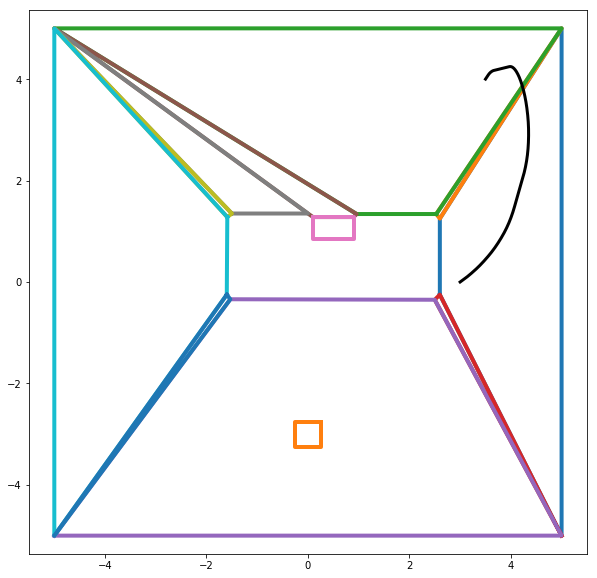

In [94]:
plot_hulls([x for x in boat.hulls.values()[1]], (boats_S_new[0,:,0], boats_S_new[0,:,1]), text=False, figure=True)


In [10]:
print boat.path

 [3]


In [ ]:
boats_S_new1 = knots_to_trajectory(boats_S, 497)
boats_S_new2 = knots_to_trajectory2(boats_S, 497)

plt.figure()
end = 50

print boats_S_new2[:,30:39,3:5]
print (boats_S_new2[:,30:39,0:2]-boats_S_new2[:,29:38,0:2])

In [148]:
print boat.angle_constraint(1, [0,0,0,0,0,0], 0, 0)

print boat.g.num_vertices()

True
48


In [117]:
print mp.GetSolution(boat.in_hull)
print mp.GetSolution(boat.angle_mod)

#print boats_S
#print boat.angle_constraint(1, boats_S[0,4], 270, 270)

print boats_S[0,:,[2,5,6,7]].T

[[ 1.  0.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.]
 [ 0.  1. -0.  0.  0.  0.]
 [ 0.  0.  1. -0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.]
 [ 0.  0.  0.  0.  0.  1.]]
[[ 0.00000000e+00  0.00000000e+00]
 [-0.00000000e+00 -1.25417210e-09]
 [-0.00000000e+00  6.48068903e-06]
 [ 6.48068903e-06 -0.00000000e+00]
 [ 6.48068903e-06 -0.00000000e+00]
 [-0.00000000e+00  0.00000000e+00]
 [ 1.11022302e-16  0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00]
 [-0.00000000e+00  6.48068903e-06]
 [ 6.48068903e-06 -0.00000000e+00]]
[[ 1.80000000e+02  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.80000000e+02  0.00000000e+00  3.59999998e+02 -3.59999998e+02]
 [ 2.70000000e+02  0.00000000e+00  9.33219220e-03 -9.33219220e-03]
 [ 2.70000000e+02  0.00000000e+00 -9.33219220e-03  9.33219220e-03]
 [ 2.70000000e+02  0.00000000e+00 -9.33219220e-03  9.33219220e-03]
 [ 2.70000000e+02 -0.00000000e+00  5.142856

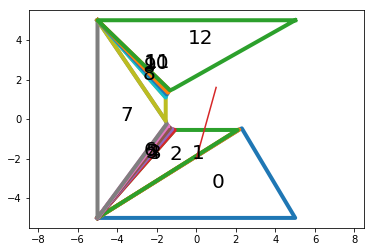

In [7]:
plt.figure()
plot_hulls([boat.g.vertex_properties["polygon"][i] for i in boat.path],figure=False)
plt.plot([0,1],[-2,1.6])
plt.show()

## MIQP - Euler

### Shape B latch Shape A

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.002956 seconds
ADDING COSTS
0.012690 seconds
ADDING CONSTRAINTS
True
0.245106 seconds
PLANNING
SolutionResult.kSolutionFound
2.321925 seconds



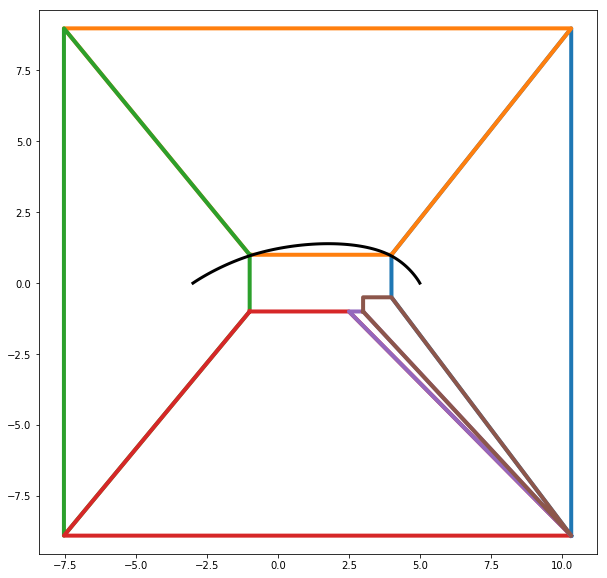

[0, 1, 2]


In [32]:
boat, boats_S, boats_U = experiment(shape_b, shape_a, [5,0], [-3,0])
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B around Shape A

In [41]:
boat, boats_S, boats_U = experiment(shape_b, shape_a, [5,0], [-2.5,.51])

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.004022 seconds
ADDING COSTS
0.011553 seconds
ADDING CONSTRAINTS
True
0.276939 seconds
PLANNING
SolutionResult.kSolutionFound
5.282127 seconds



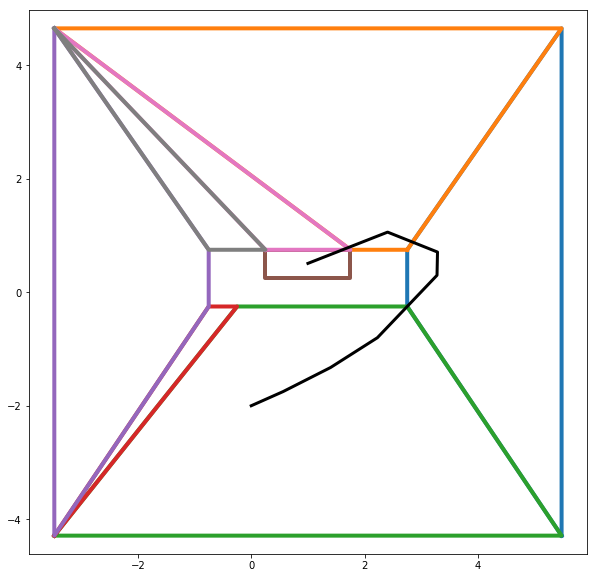

[2, 0, 1, 6, 5]


In [60]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B around shape B

In [5]:
boat, boats_S, boats_U = experiment(shape_b, shape_b, [0,3], [0,-3])
write_experiment(boat, boats_S, boats_U, 'avoid')

NameError: name 'experiment' is not defined

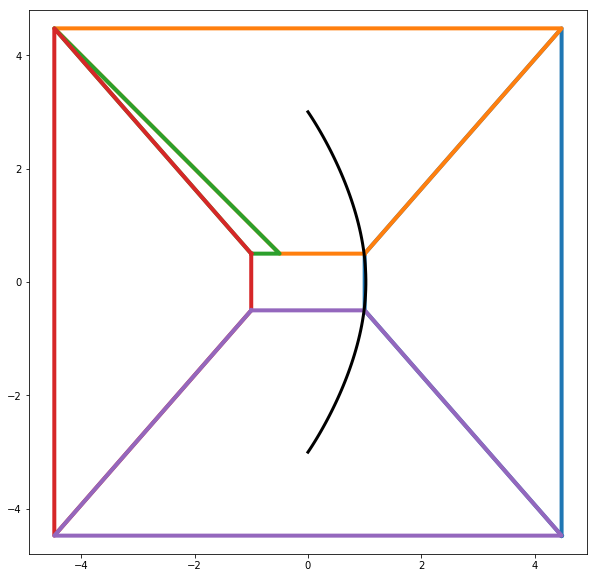

[1, 0, 4]


In [666]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path

### Shape B latch to Shape B

In [318]:
boat, boats_S, boats_U = experiment(shape_b, shape_b, [1,3], [0,0.51])
write_experiment(boat, boats_S, boats_U, 'latch')

1
INITIALIZED 1 ShapeBoat boats
boats_S:(1, 101, 4), boats_U:(1, 100, 2), time_array:(101,)
Number of decision vars 604
0.007476 seconds
ADDING COSTS
0.018638 seconds
ADDING CONSTRAINTS
True
0.138284 seconds
PLANNING
SolutionResult.kSolutionFound
0.026745 seconds



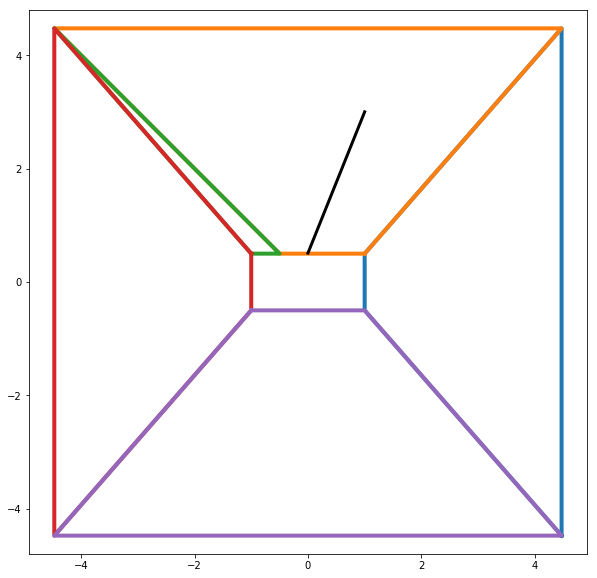

[1]


In [319]:
plot_hulls(boat.hulls, (boats_S[0,:,0], boats_S[0,:,1]), text=False)
print boat.hull_path